In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import get_window
from scipy.signal import find_peaks
from scipy.io import wavfile
from scipy.signal import savgol_filter
import IPython
import tensorflow as tf

In [8]:
fs, x = wavfile.read("samples/recording2.wav")
d = x
x = x / np.max(abs(x))

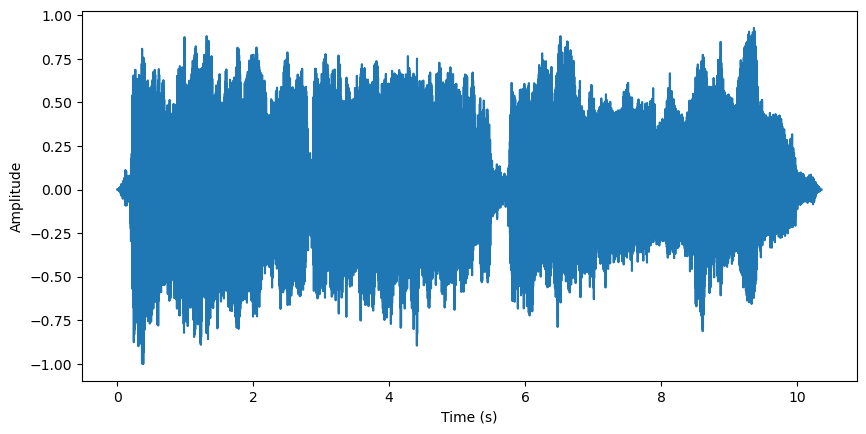

In [9]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
xTime = np.arange(len(x)) / fs
plt.plot(xTime, x)
IPython.display.Audio(x, rate=fs)

In [10]:
M = 8191
N = 8192
H = 2048

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [11]:
w  = get_window('blackman', M)
w = w / sum(w)

In [29]:
def computeSTFT(x):
    stft = []
    t_onset = []
    
    l = 0
    while l < len(x) - M:
        y = x[l: l + M]
        
        rmsframe = np.sqrt(np.dot(y, y) / M)    
        
        if rmsframe >= 0.1:
            y = y / np.max(abs(y))
            y = y * w

            fftBuffer = np.zeros(N)
            fftBuffer[: hM1] = y[hM2:] 
            fftBuffer[N - hM2:] = y[: hM2]

            X = fft(fftBuffer)
            absX = abs(X)
            absX[absX < np.finfo(float).eps] = np.finfo(float).eps
            mX = 10 * np.log10(absX)

            stft.append(mX)
        else:
            try:
                t_onset.append(len(stft))
            except:
                pass

        l += H
    
    return stft, t_onset

In [30]:
stft, t_onset = computeSTFT(x)

In [31]:
timeSteps = np.arange(len(stft)) * H / fs
frequencies = np.arange(N) * fs / N
cutoff = int(1010 * N / fs)

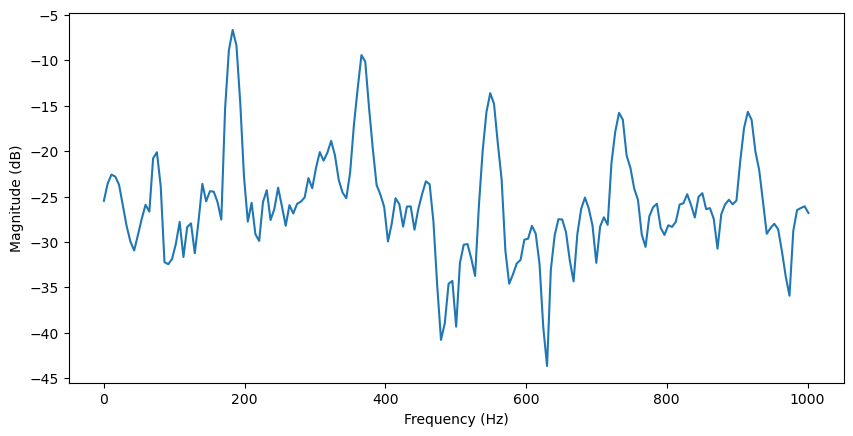

In [32]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], stft[50][:cutoff])

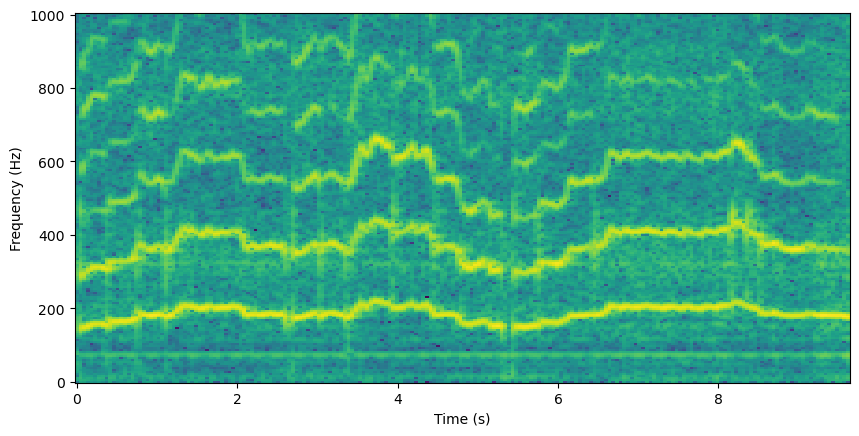

In [33]:
stft = np.array(stft)

plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:cutoff], stft.T[:cutoff])

In [34]:
peaks = []
k = 15

for frame_index in range(len(stft)):
    dft = stft[frame_index][: cutoff]
    dft_savgol = savgol_filter(dft, window_length=15, polyorder=5)

    bin = k
    while bin < len(dft) - 20: 
        if dft_savgol[bin] < -25: 
            bin += 1
            continue

        if dft_savgol[bin - 1] < dft_savgol[bin] and dft_savgol[bin] > dft_savgol[bin + 1]:# and model.predict(np.array([dft_savgol[bin: bin + 20][..., np.newaxis]]), verbose=False)[0][0] < 0.5:
            window = np.zeros(len(dft_savgol)) - 100
            window[bin: bin + 20] = dft[bin: bin + 20]

            peak = np.argmax(window) 

            if frame_index > 59 or frame_index in t_onset:
                k = 15
            else:
                k = max(peak - 10, 15)

            peaks.append(peak)

            break                
        else:
            bin += 1

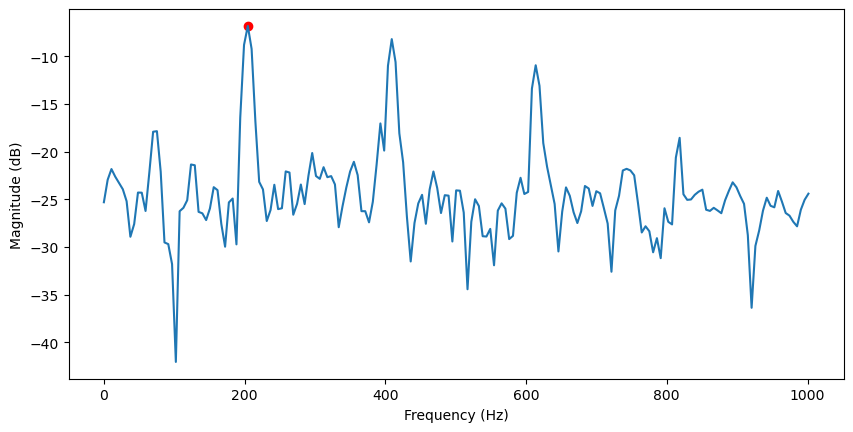

In [35]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], stft[150][:cutoff])
plt.scatter(peaks[150] * fs / N, stft[150][int(peaks[150])], c='r')
plt.savefig('peak.png')

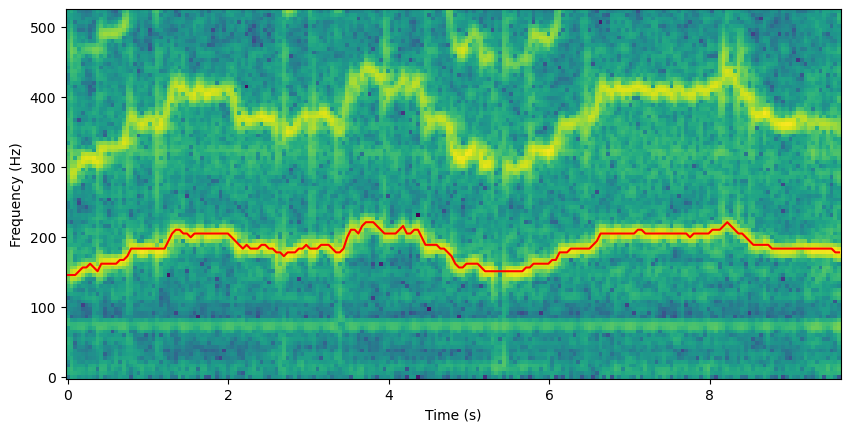

In [37]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:int(cutoff/2) + 5], stft.T[:int(cutoff/2) + 5])
plt.plot(timeSteps, np.array(peaks) * fs / N, c='red')
plt.savefig('pitch.png')